# **U-Net을 이용한 차선 감지(PyTorch)**

## **1. 필요한 라이브러리 가져오기**

In [ ]:
import os
import random
import time

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler

## **2. 데이터셋 디렉토리 정의**

In [ ]:
# Directory paths for the dataset
train_image_dir = './train'
train_mask_dir = './train_label'
val_image_dir = './val'
val_mask_dir = './val_label'

## **3. 데이터셋 확인**

### 3.1 이미지 속성 분석

In [ ]:
def analyze_image_properties(image_dir):
    image_files = os.listdir(image_dir)
    resolutions = []
    channels = []
    missing_files = []

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        try:
            with Image.open(img_path) as img:
                # 해상도(너비, 높이) 수집
                resolutions.append(img.size)  # (너비, 높이)

                # 채널 수 수집
                channels.append(len(img.getbands()))  # RGB = 3, Grayscale = 1

        except Exception as e:
            print(f"Error loading image {img_file}: {e}")
            missing_files.append(img_file)

    return resolutions, channels, missing_files

In [ ]:
# 학습용 이미지와 마스크의 속성 분석
train_img_resolutions, train_img_channels, train_img_missing_files = analyze_image_properties(train_image_dir)
train_label_resolutions, train_label_channels, train_label_missing_files = analyze_image_properties(train_mask_dir)

In [ ]:
# 검증 이미지와 마스크의 속성 분석
val_img_resolutions, val_img_channels, val_img_missing_files = analyze_image_properties(val_image_dir)
val_label_resolutions, val_label_channels, val_label_missing_files = analyze_image_properties(val_mask_dir)

In [ ]:
# 결과 표시
print(f"Analysis of Train image dataset")
print(f"List of resolutions: {set(train_img_resolutions)}")
print(f"List of channels: {set(train_img_channels)}")
print(f"Missing files: {train_img_missing_files}")

print(f"\nAnalysis of Train mask dataset")
print(f"List of resolutions: {set(train_label_resolutions)}")
print(f"List of channels: {set(train_label_channels)}")
print(f"Missing files: {train_label_missing_files}")

print(f"\nAnalysis of Validation image dataset")
print(f"List of resolutions: {set(val_img_resolutions)}")
print(f"List of channels: {set(val_img_channels)}")
print(f"Missing files: {val_img_missing_files}")

print(f"\nAnalysis of Validation mask dataset")
print(f"List of resolutions: {set(val_label_resolutions)}")
print(f"List of channels: {set(val_label_channels)}")
print(f"Missing files: {val_label_missing_files}")

Analysis of Train image dataset
List of resolutions: {(1024, 512)}
List of channels: {3}
Missing files: []

Analysis of Train mask dataset
List of resolutions: {(1024, 512)}
List of channels: {1}
Missing files: []

Analysis of Validation image dataset
List of resolutions: {(1024, 512)}
List of channels: {3}
Missing files: []

Analysis of Validation mask dataset
List of resolutions: {(1024, 512)}
List of channels: {1}
Missing files: []


### 3.2 마스크 파일의 고유 클래스 분석

In [ ]:
def get_unique_classes_from_dir(mask_dir):
    mask_files = os.listdir(mask_dir)
    all_unique_classes = set()

    for mask_file in mask_files:
        mask_path = os.path.join(mask_dir, mask_file)
        try:
            with Image.open(mask_path) as mask:
                mask_array = np.array(mask)

                # 고유 클래스 확인
                unique_classes = np.unique(mask_array)

                # 모든 고유 클래스 업데이트
                all_unique_classes.update(unique_classes)
        except Exception as e:
            print(f"Error loading mask {mask_file}: {e}")

    return all_unique_classes

In [ ]:
train_unique_classes = get_unique_classes_from_dir(train_mask_dir)
val_unique_classes = get_unique_classes_from_dir(val_mask_dir)

In [ ]:
# 고유 클래스 출력
print(f"Unique classes in Train masks: {train_unique_classes}")
print(f"Number of classes in Train masks: {len(train_unique_classes)}")

print(f"Unique classes in Val masks: {val_unique_classes}")
print(f"Number of classes in Val masks: {len(val_unique_classes)}")

Unique classes in Train masks: {np.uint8(0), np.uint8(1), np.uint8(2)}
Number of classes in Train masks: 3
Unique classes in Val masks: {np.uint8(0), np.uint8(1), np.uint8(2)}
Number of classes in Val masks: 3


## **4. 영역분할(Segmentation)을 위한 사용자 정의 데이터셋 생성**

### 4.1 영역분할 작업을 위한 사용자 정의 데이터셋 클래스 정의

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        label_name = self.images[idx].replace('.png', '_label.png')
        label_path = os.path.join(self.label_dir, label_name)

        # 이미지와 마스크 읽기
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(label_path).convert('L')  # 그레이스케일 마스크

        # 이미지와 마스크 모두에 변환 적용
        if self.transform:
            image = self.transform(image)
            mask = TF.resize(mask, (256, 256), interpolation=Image.NEAREST)

        mask = torch.from_numpy(np.array(mask)).long()  # 마스크를 텐서로 변환

        return image, mask

### 4.2 변환 정의

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

### 4.3 데이터 로더 생성

In [ ]:
train_dataset = SegmentationDataset(image_dir=train_image_dir, label_dir=train_mask_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = SegmentationDataset(image_dir=val_image_dir, label_dir=val_mask_dir, transform=train_transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

## **5. 이미지 분할을 위한 U-Net 아키텍처 정의**

### 5.1 U-Net 아키텍처 정의

In [ ]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()

        # Contracting path
        self.encoder1 = self.conv_block(3, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        self.encoder5 = self.conv_block(512, 1024)

        # Bottleneck
        self.bottleneck = self.conv_block(1024, 2048)

        # Expanding path
        self.upconv5 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.decoder5 = self.conv_block(2048, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)

        # Final output layer for multi-class segmentation
        self.conv_last = nn.Conv2d(64, num_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )
        return block

    def forward(self, x):
        # Contracting path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.encoder3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.encoder4(F.max_pool2d(enc3, kernel_size=2))
        enc5 = self.encoder5(F.max_pool2d(enc4, kernel_size=2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc5, kernel_size=2))

        # Expanding path
        dec5 = self.upconv5(bottleneck)
        dec5 = torch.cat((enc5, dec5), dim=1)
        dec5 = self.decoder5(dec5)

        dec4 = self.upconv4(dec5)
        dec4 = torch.cat((enc4, dec4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((enc3, dec3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((enc1, dec1), dim=1)
        dec1 = self.decoder1(dec1)

        # Final output layer (logits)
        return self.conv_last(dec1)

### 5.2 3개 클래스에 대한 U-Net 모델 초기화

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(num_classes=3).to(device)
#model.load_state_dict(torch.load('best_model.pth'))

## **6. 손실함수 및 최적화 함수 정의**

In [ ]:
# 손실함수
criterion = nn.CrossEntropyLoss()

# 최적화 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)

## **7. 매트릭 정의: IoU 및 Dice 계수**

### 7.1 IoU 계산 함수

In [ ]:
def calculate_iou(preds, masks, num_classes):
    ious = []
    preds = torch.argmax(preds, dim=1)  # 각 픽셀에 대한 예측 클래스 가져오기
    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        mask_cls = (masks == cls).float()

        intersection = torch.sum(pred_cls * mask_cls)
        union = torch.sum(pred_cls) + torch.sum(mask_cls) - intersection

        if union == 0:
            ious.append(1.0)  # 합집합이 없다면 IoU는 완전한 것으로 간주
        else:
            ious.append((intersection / union).item())

    return sum(ious) / len(ious)  # 모든 클래스의 평균 IoU 반환

### 7.2 Dice 계수 계산 함수

In [ ]:
def calculate_dice(preds, masks, num_classes):
    dices = []
    preds = torch.argmax(preds, dim=1)  # 각 픽셀에 대한 예측 클래스 가져오기
    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        mask_cls = (masks == cls).float()

        intersection = torch.sum(pred_cls * mask_cls)
        dice = (2 * intersection) / (torch.sum(pred_cls) + torch.sum(mask_cls))

        if torch.sum(pred_cls) + torch.sum(mask_cls) == 0:
            dices.append(1.0)
        else:
            dices.append(dice.item())

    return sum(dices) / len(dices)  # 모든 클래스의 평균 Dice 계수를 반환

## **8. 모델 훈련 및 검증**

In [ ]:
num_epochs = 50
train_loss_list = []
val_loss_list = []
iou_list = []
dice_list = []

In [ ]:
num_classes = 3  # 분할 클래스의 개수

In [ ]:
# 학습률 스케줄러(검증 손실이 정점에 도달하면 LR을 줄임)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
save_path = 'best_model.pth'

In [ ]:
# 조기 종료 설정
early_stopping_patience = 5
early_stopping_counter = 0
best_val_loss = float('inf')

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # 훈련(학습) 루프
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1} [Training]"):
        images = images.to(device)
        masks = masks.to(device).long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 검증 루프
    model.eval()
    val_loss = 0.0
    iou_total = 0.0
    dice_total = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1} [Validation]"):
            images = images.to(device)
            masks = masks.to(device).long()

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            iou = calculate_iou(outputs, masks, num_classes=num_classes)
            dice = calculate_dice(outputs, masks, num_classes=num_classes)

            iou_total += iou
            dice_total += dice

    # 평균값 계산
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_iou = iou_total / len(val_loader)
    avg_dice = dice_total / len(val_loader)

    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    iou_list.append(avg_iou)
    dice_list.append(avg_dice)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    print(f"MIoU: {avg_iou:.4f}, Dice Coefficient: {avg_dice:.4f}")

    # 학습률 스케줄러 업데이트
    scheduler.step(avg_val_loss)

    # 조기 종료 로직
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        early_stopping_counter = 0
        print("Validation loss improved, resetting early stopping counter.")
    else:
        early_stopping_counter += 1
        print(f"Validation loss did not improve for {early_stopping_counter} epochs.")
        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

Epoch 1 [Training]:   0%|          | 0/193 [00:00<?, ?it/s]

Epoch 1 [Validation]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.3037, Validation Loss: 0.0700
MIoU: 0.3286, Dice Coefficient: 0.3310
Validation loss improved, resetting early stopping counter.


Epoch 2 [Training]:   0%|          | 0/193 [00:00<?, ?it/s]

Epoch 2 [Validation]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0729, Validation Loss: 0.0781
MIoU: 0.3286, Dice Coefficient: 0.3310
Validation loss did not improve for 1 epochs.


Epoch 3 [Training]:   0%|          | 0/193 [00:00<?, ?it/s]

Epoch 3 [Validation]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 1.2368, Validation Loss: 0.1195
MIoU: 0.3286, Dice Coefficient: 0.3310
Validation loss did not improve for 2 epochs.


Epoch 4 [Training]:   0%|          | 0/193 [00:00<?, ?it/s]

Epoch 4 [Validation]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.1015, Validation Loss: 0.0972
MIoU: 0.3286, Dice Coefficient: 0.3310
Validation loss did not improve for 3 epochs.


Epoch 5 [Training]:   0%|          | 0/193 [00:00<?, ?it/s]

Epoch 5 [Validation]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0871, Validation Loss: 0.0902
MIoU: 0.3286, Dice Coefficient: 0.3310
Validation loss did not improve for 4 epochs.


Epoch 6 [Training]:   0%|          | 0/193 [00:00<?, ?it/s]

Epoch 6 [Validation]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0767, Validation Loss: 0.0734
MIoU: 0.3286, Dice Coefficient: 0.3310
Validation loss did not improve for 5 epochs.
Early stopping triggered at epoch 6.


## **9. 결과 표시**

In [ ]:
# 훈련 및 검증 손실, MIoU 및 Dice 메트릭을 플로팅하는 함수
def plot_metrics(train_loss_list, val_loss_list, iou_list, dice_list):
    epochs = range(1, len(train_loss_list) + 1)

    # 손실 값 플로팅
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss_list, label='Train Loss')
    plt.plot(epochs, val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # MIoU 와 Dice 계수 플로팅
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, iou_list, label='Mean IoU', color='blue', alpha=0.5)
    plt.plot(epochs, dice_list, label='Dice Coefficient', color='green', alpha=0.5)
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.title('MIoU and Dice Coefficient Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

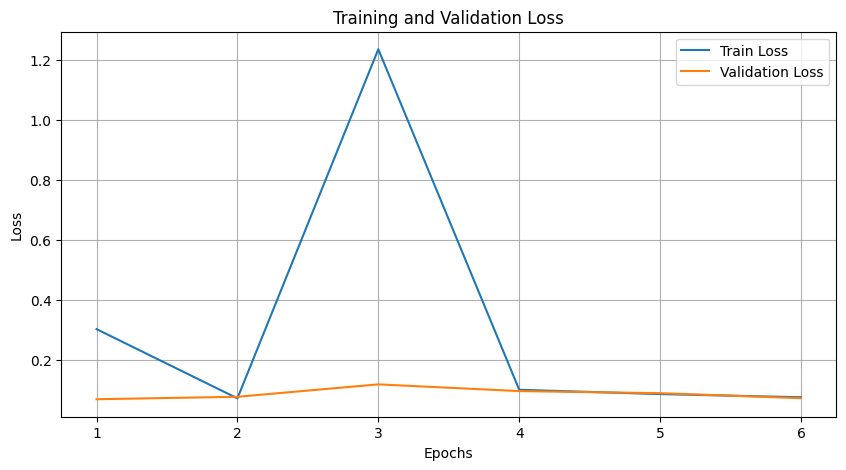

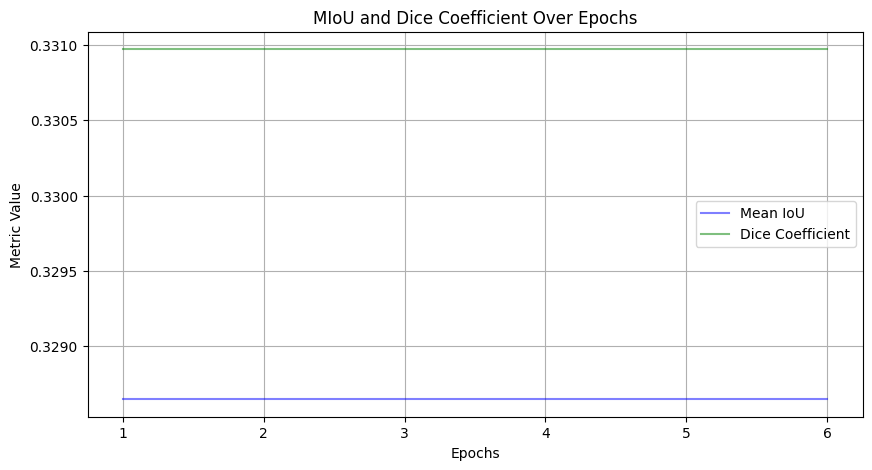

In [ ]:
# Plot the metrics
plot_metrics(train_loss_list, val_loss_list, iou_list, dice_list)

## **10. 예측 시각화**

In [ ]:
def visualize_random_predictions(model, dataloader, device, num_images=5):
    model.eval()  # 모델을 평가 모드로 설정

    dataset_size = len(dataloader.dataset)
    random_indices = random.sample(range(dataset_size), num_images)

    images_so_far = 0
    fig, ax = plt.subplots(num_images, 3, figsize=(10, num_images * 5))

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(dataloader):
            batch_size = images.size(0)
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size

            valid_indices = [i for i in random_indices if start_idx <= i < end_idx]

            if len(valid_indices) == 0:
                continue

            images = images.to(device)
            masks = masks.to(device)

            # 예측
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in valid_indices:
                local_idx = i - start_idx

                pred_mask = preds[local_idx].cpu().numpy()
                true_mask = masks[local_idx].cpu().numpy()

                ax[images_so_far, 0].imshow(images[local_idx].cpu().permute(1, 2, 0))
                ax[images_so_far, 0].set_title('Input Image')

                ax[images_so_far, 1].imshow(true_mask, cmap='gray')
                ax[images_so_far, 1].set_title('True Mask')

                ax[images_so_far, 2].imshow(pred_mask, cmap='gray')
                ax[images_so_far, 2].set_title('Predicted Mask')

                images_so_far += 1

                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.show()
                    return

    plt.tight_layout()
    plt.show()

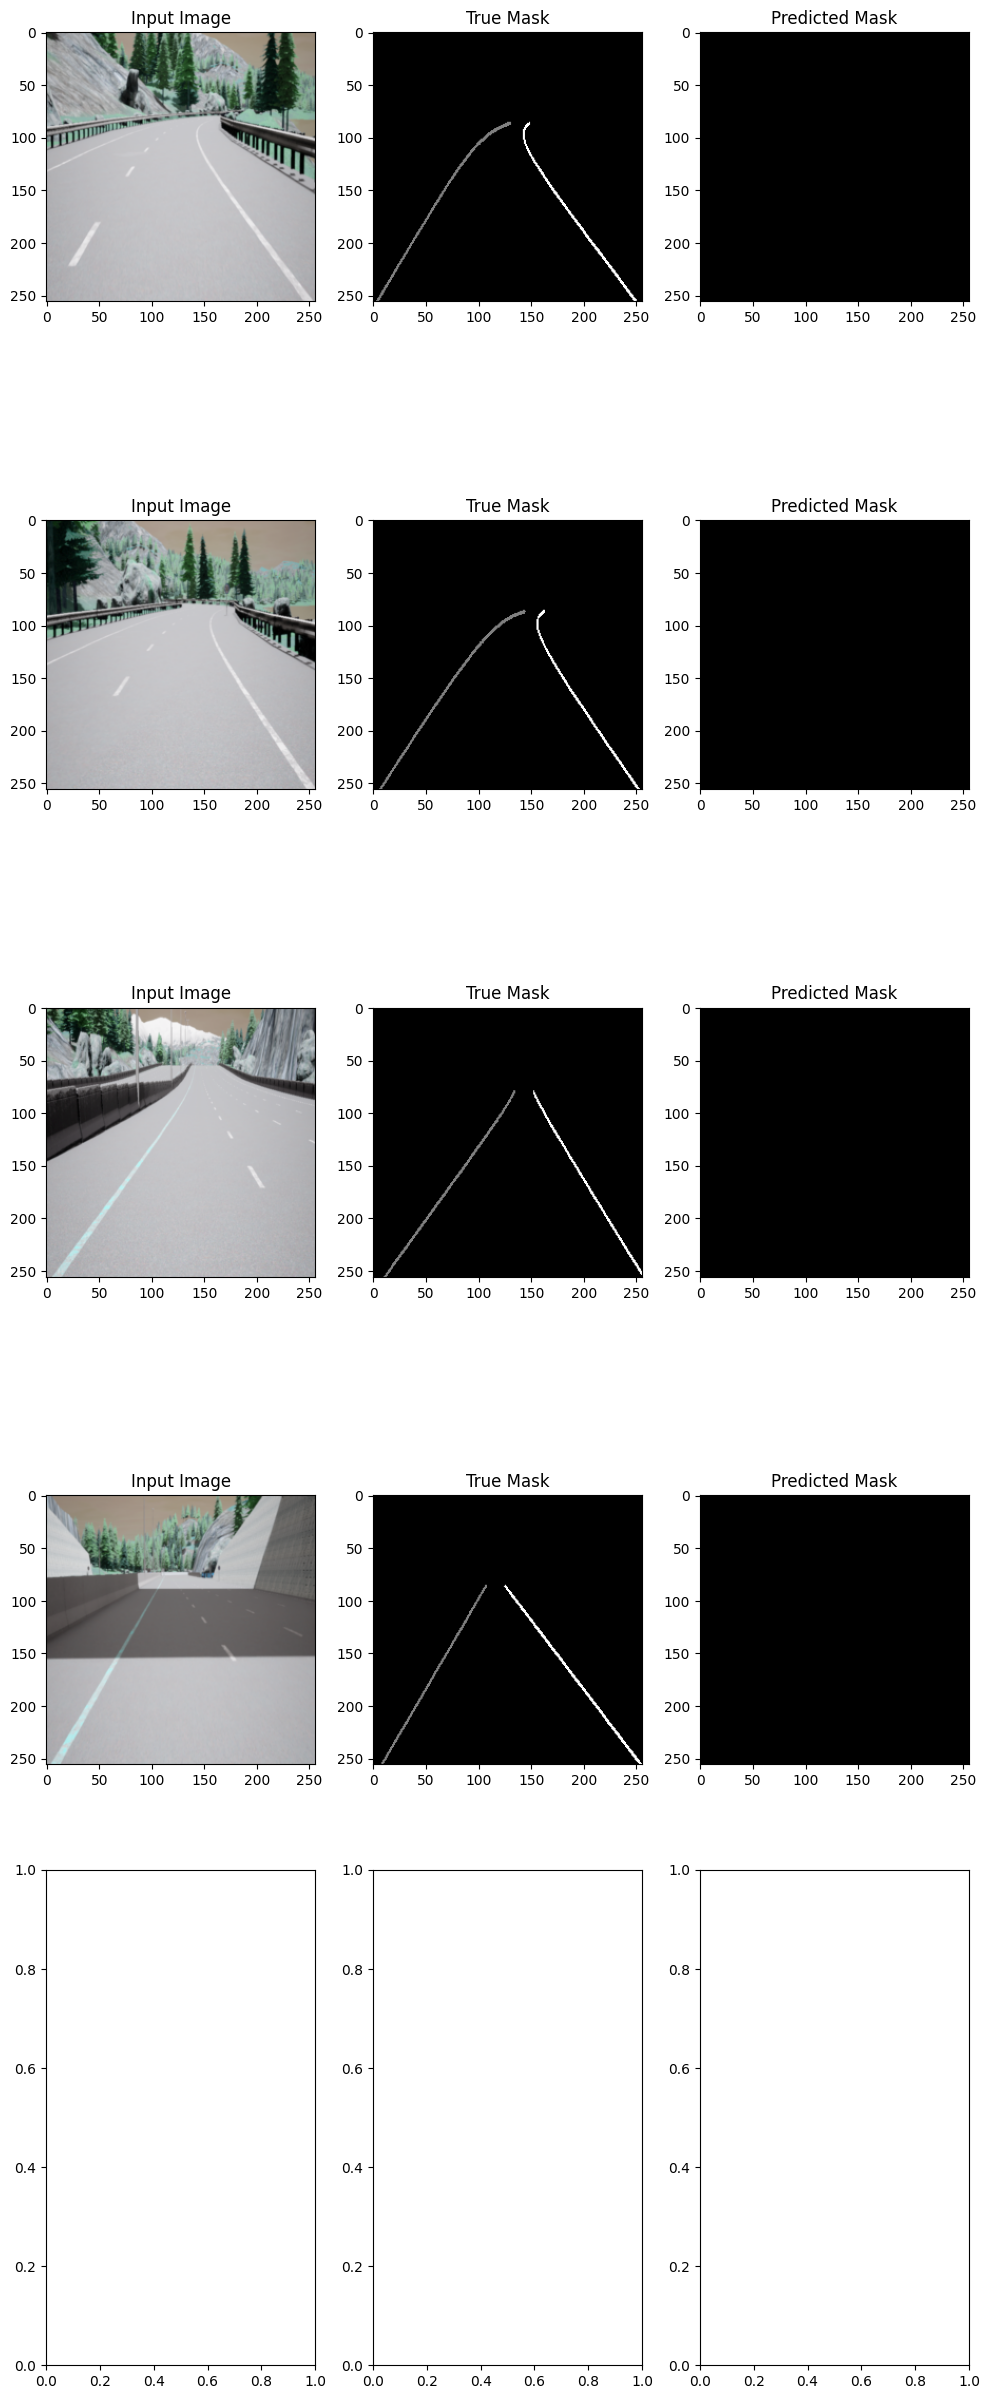

In [ ]:
# Visualize predictions on validation set
visualize_random_predictions(model, val_loader, device, num_images=5)

## **11. 추론 속도 및 추정 FPS 측정**

- 추론 속도와 추정 FPS (Frames Per Second, 초당 프레임 수)를 측정해야 하는 이유
    - 이 단계에서는 훈련된 모델이 데이터 세트의 단일 이미지에 대해 추론을 수행하는 데 걸리는 평균 시간을 평가함
    - 이를 통해 배포 과정에서 모델의 성능을 명확하게 파악할 수 있음
    - 추론 시간을 기반으로 모델이 1초에 처리할 수 있는 이미지 수를 정량화하는 초당 프레임 수(FPS)를 계산
    - FPS
        - 비디오 스트리밍, 자율주행 또는 기타 시간에 민감한 작업 등 실시간 애플리케이션에 중요한 지표
        - 모델이 동적이고 빠르게 변화하는 환경에서 얼마나 효율적으로 예측을 제공할 수 있는지를 보여줌

In [ ]:
# 이미지당 추론 시간 측정
def measure_inference_speed(model, dataloader, device, num_images=10):
    model.eval()  # 모델을 평가 모드로 설정
    total_time = 0.0
    images_processed = 0

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)

            start_time = time.time()
            outputs = model(images)
            end_time = time.time()

            inference_time = end_time - start_time
            total_time += inference_time
            images_processed += len(images)

            if images_processed >= num_images:
                break

    avg_inference_time = total_time / images_processed
    print(f"Average inference time per image: {avg_inference_time:.4f} seconds")

    return avg_inference_time

In [ ]:
# 검증 세트에서 추론 속도 측정
avg_inference_time = measure_inference_speed(model, val_loader, device, num_images=10)

Average inference time per image: 0.0001 seconds


In [ ]:
fps = 1 / avg_inference_time  # FPS(초당 프레임 수) 계산
print(f"Estimated FPS (Frames Per Second): {fps:.2f} FPS")

Estimated FPS (Frames Per Second): 17123.98 FPS
